In [1]:
# mlxtend 모듈 없으면 install하기
import matplotlib.pyplot as plt
import matplotlib.colors as mcl
import pandas as pd
import numpy as np
 
from matplotlib.colors import LinearSegmentedColormap
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules


In [21]:
store_df = pd.read_csv("C:/pythondata/data/store_data.csv", header=None)

In [22]:
store_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
1,burgers,meatballs,eggs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chutney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,turkey,avocado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mineral water,milk,energy bar,whole wheat rice,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# 빈발 품목 집합 구하기 -> 각 행에 대해서 품목을 리스트로 만들어주고 이를 다시 리스트로 모아줘야 함. 리스트의 리스트 만들기

records = []
for i in range(len(store_df)):
    records.append([str(store_df.values[i,j]) \
                    for j in range(len(store_df.columns)) if not pd.isna(store_df.values[i,j])])


In [24]:
# mlxtend를 사용하기 위한 데이터프레임 만들기. 각 행별로 품목이 포함되어 있으면 1 아니면 0

te = TransactionEncoder()
te_ary = te.fit(records).transform(records, sparse=True)
te_df = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)


In [25]:
te_df.head()

,asparagus,almonds,antioxydant juice,asparagus,avocado,babies food,bacon,barbecue sauce,black tea,blueberries,...,turkey,vegetables mix,water spray,white wine,whole weat flour,whole wheat pasta,whole wheat rice,yams,yogurt cake,zucchini
0,0,1,1,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [26]:
# 빈발 품목 집합 만들기 -> 최소 지지도는 0.005, 품목 집합 최대 개수는 3으로 설정
# use_columns를 True로 설정하면 품목 집합을 칼럼이름으로 지정. 진행 상황을 보기 위해 vervose = 1로 지정. 
# 품목 집합개수는 length칼럼으로 나타내고, 지지도를 기준으로 내림차순

frequent_itemset = apriori(te_df,
                           min_support=0.005, 
                           max_len=3, 
                           use_colnames=True, 
                           verbose=1 
                          )
frequent_itemset['length'] = frequent_itemset['itemsets'].map(lambda x: len(x))
frequent_itemset.sort_values('support',ascending=False,inplace=True)


Processing 30285 combinations | Sampling itemset size 3


In [27]:
frequent_itemset

,support,itemsets,length
60,0.238368,(mineral water),1
27,0.179709,(eggs),1
83,0.174110,(spaghetti),1
33,0.170911,(french fries),1
20,0.163845,(chocolate),1
...,...,...,...
646,0.005066,"(mineral water, eggs, tomatoes)",3
648,0.005066,"(olive oil, eggs, spaghetti)",3
674,0.005066,"(mineral water, soup, frozen vegetables)",3
680,0.005066,"(ground beef, mineral water, grated cheese)",3


In [28]:
# 연관규칙을 뽑아내는 코드. 신뢰도가 0.005 이상인 연관규칙만 뽑아냄.

association_rules_df = association_rules(frequent_itemset, 
                                         metric='confidence', 
                                         min_threshold=0.005,
                                        )
all_confidences = []
collective_strengths = []
cosine_similarities = []
for _,row in association_rules_df.iterrows():
    all_confidence_if = list(row['antecedents'])[0]
    all_confidence_then = list(row['consequents'])[0]
    if row['antecedent support'] <= row['consequent support']:
        all_confidence_if = list(row['consequents'])[0]
        all_confidence_then = list(row['antecedents'])[0]
    all_confidence = {all_confidence_if+' => '+all_confidence_then : \
                      row['support']/max(row['antecedent support'], row['consequent support'])}
    all_confidences.append(all_confidence)
    
    violation = row['antecedent support'] + row['consequent support'] - 2*row['support']
    ex_violation = 1-row['antecedent support']*row['consequent support'] - \
                    (1-row['antecedent support'])*(1-row['consequent support'])
    collective_strength = (1-violation)/(1-ex_violation)*(ex_violation/violation)
    collective_strengths.append(collective_strength)
    
    cosine_similarity = row['support']/np.sqrt(row['antecedent support']*row['consequent support'])
    cosine_similarities.append(cosine_similarity)
    
association_rules_df['all-confidence'] = all_confidences
association_rules_df['collective strength'] = collective_strengths
association_rules_df['cosine similarity'] = cosine_similarities


In [29]:
association_rules_df.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,all-confidence,collective strength,cosine similarity
0,(spaghetti),(mineral water),0.174110,0.238368,0.059725,0.343032,1.439085,0.018223,1.159314,0.369437,{'mineral water => spaghetti': 0.2505592841163...,1.185493,0.293172
1,(mineral water),(spaghetti),0.238368,0.174110,0.059725,0.250559,1.439085,0.018223,1.102008,0.400606,{'mineral water => spaghetti': 0.2505592841163...,1.185493,0.293172
2,(mineral water),(chocolate),0.238368,0.163845,0.052660,0.220917,1.348332,0.013604,1.073256,0.339197,{'mineral water => chocolate': 0.220917225950783},1.135588,0.266463
3,(chocolate),(mineral water),0.163845,0.238368,0.052660,0.321400,1.348332,0.013604,1.122357,0.308965,{'mineral water => chocolate': 0.220917225950783},1.135588,0.266463
4,(mineral water),(eggs),0.238368,0.179709,0.050927,0.213647,1.188845,0.008090,1.043158,0.208562,{'mineral water => eggs': 0.21364653243847875},1.076638,0.246056


In [30]:
# 결과를 5행만 출력해보면

max_i = 4
for i, row in association_rules_df.iterrows():
    print("Rule: " + list(row['antecedents'])[0] + " => " + list(row['consequents'])[0])
 
    print("Support: " + str(round(row['support'],2)))
 
    print("Confidence: " + str(round(row['confidence'],2)))
    print("Lift: " + str(round(row['lift'],2)))
    print("=====================================")
    if i==max_i:
        break


Rule: spaghetti => mineral water
Support: 0.06
Confidence: 0.34
Lift: 1.44
Rule: mineral water => spaghetti
Support: 0.06
Confidence: 0.25
Lift: 1.44
Rule: mineral water => chocolate
Support: 0.05
Confidence: 0.22
Lift: 1.35
Rule: chocolate => mineral water
Support: 0.05
Confidence: 0.32
Lift: 1.35
Rule: mineral water => eggs
Support: 0.05
Confidence: 0.21
Lift: 1.19


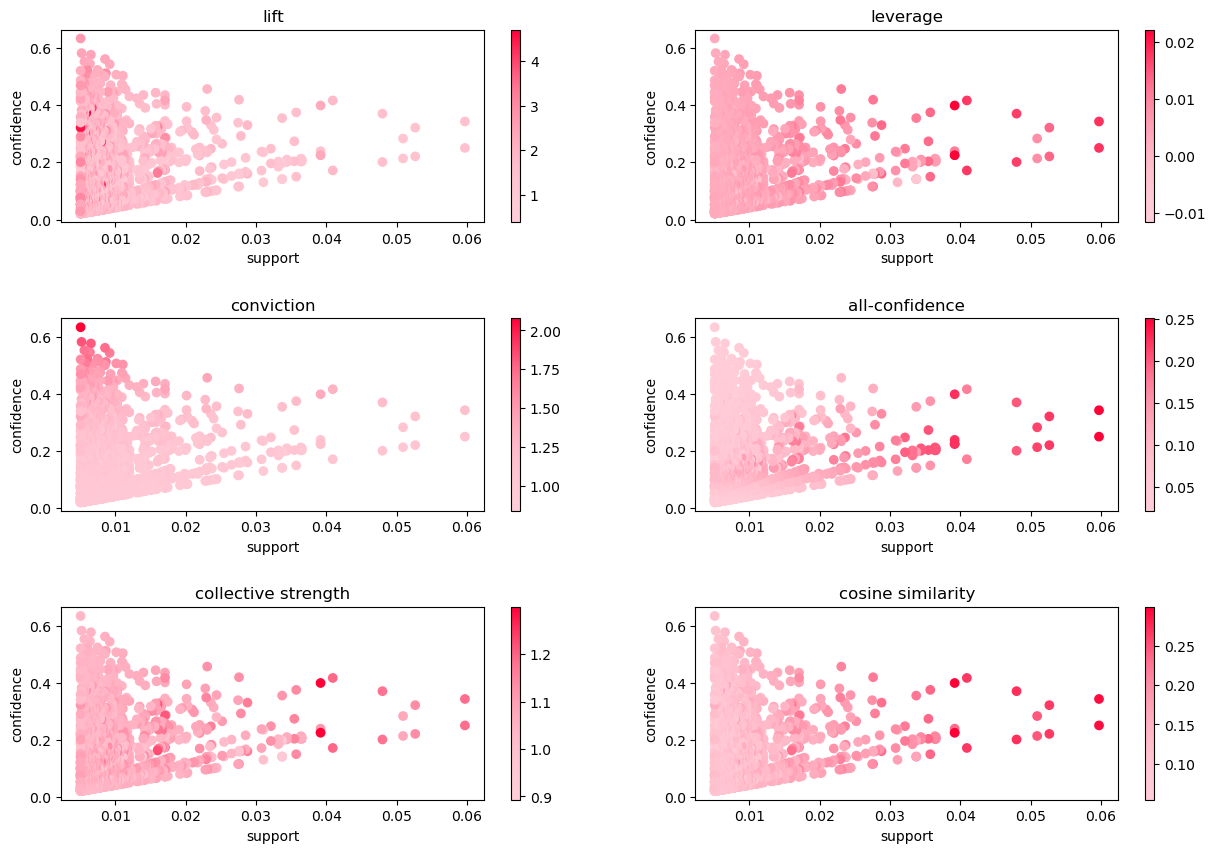

In [31]:
# 연관 규칙 분석 결과의 시각화. x축은 지지도, y축은 신뢰도

support = association_rules_df['support']
confidence = association_rules_df['confidence']
 
h = 347
s = 1
v = 1
colors = [
    mcl.hsv_to_rgb((h/360, 0.2, v)),
    mcl.hsv_to_rgb((h/360, 0.55, v)),
    mcl.hsv_to_rgb((h/360, 1, v))
]
cmap = LinearSegmentedColormap.from_list('my_cmap',colors,gamma=2)
 
measures = ['lift', 'leverage', 'conviction', 
            'all-confidence', 'collective strength', 'cosine similarity']
 
fig = plt.figure(figsize=(15,10))
fig.set_facecolor('white')
for i, measure in enumerate(measures):
    ax = fig.add_subplot(320+i+1)
    if measure != 'all-confidence':
        scatter = ax.scatter(support,confidence,c=association_rules_df[measure],cmap=cmap)
    else:
        scatter = ax.scatter(support,confidence,c=association_rules_df['all-confidence'].map(lambda x: [v for k,v in x.items()][0]),cmap=cmap)
    ax.set_xlabel('support')
    ax.set_ylabel('confidence')
    ax.set_title(measure)
    
    fig.colorbar(scatter,ax=ax)
fig.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()
